In [4]:
import numpy as np, torch, matplotlib.pyplot as plt
import os
import sys

current_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_dir, "../src"))

if module_path not in sys.path:
    sys.path.append(module_path)

dpo_path = '../src/best_dpo_policy.pth'

horizon = 50
horizon_base = 50

Creating Path with step 3
Resetting environment. Previous state: [0.05 0.05], Counter: 0
step   0  legal=319


/var/folders/x6/hhp417nn6td5qzxnvywdjbv00000gp/T/ipykernel_38510/263237421.py:325: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  two_score   = float(scores[idx_best2])


Step called. Counter: 0, Horizon: 50
Distance: 1.1909659944767523
step   1  legal=342
Step called. Counter: 1, Horizon: 50
Distance: 1.1160645142642964
step   2  legal=342
Step called. Counter: 2, Horizon: 50
Distance: 1.049571341072154
step   3  legal=342
Step called. Counter: 3, Horizon: 50
Distance: 0.9931767214348108
step   4  legal=342
Step called. Counter: 4, Horizon: 50
Distance: 0.9486832980505137
step   5  legal=342
Step called. Counter: 5, Horizon: 50
Distance: 0.9178235124467011
step   6  legal=342
Step called. Counter: 6, Horizon: 50
Distance: 0.8788006408344822
step   7  legal=344
Step called. Counter: 7, Horizon: 50
Distance: 0.8416654141109637
step   8  legal=384
Step called. Counter: 8, Horizon: 50
Distance: 0.721737176511563
step   9  legal=379
Step called. Counter: 9, Horizon: 50
Distance: 0.6248847910925308
step  10  legal=355
Step called. Counter: 10, Horizon: 50
Distance: 0.6450048623206581
step  11  legal=329
Step called. Counter: 11, Horizon: 50
Distance: 0.68584

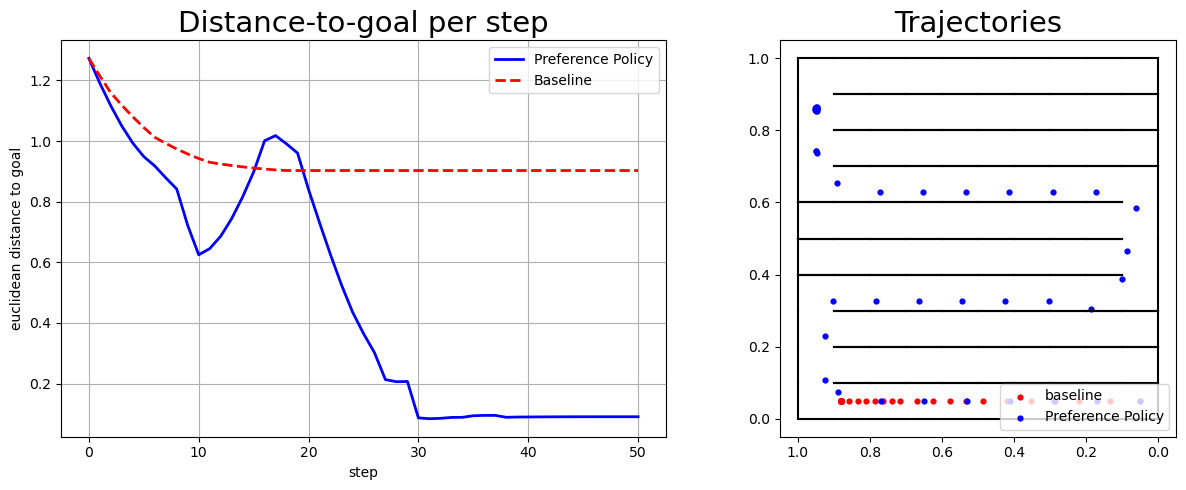

In [5]:
import numpy as np, torch, matplotlib.pyplot as plt
from maze import Maze
from maze_env import MazeEnv, draw_map
from maze_env import PolicyNetwork
from maze_env import intersect

# utils.py (o direttamente in make_comparison.ipynb)

def best_improving_action(env, acts, ref_metric, tol=1e-6):
    """
    Ritorna la prima azione che riduce di almeno `tol`
    il valore di ref_metric(s') rispetto a quello corrente.
    Se nessuna azione migliora, restituisce None.
    """
    best_a, best_val = None, ref_metric  # migliore finora (deve essere < ref)
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        s1 = env.state + np.array([dx, dy])

        # qui usiamo la distanza al goal come metrica di riferimento
        val = np.linalg.norm(env.goal - s1)

        # opzionale: scarta subito se la mossa collide
        if env.point_collision(s1[0], s1[1]):
            continue

        if val < best_val - tol:
            best_val, best_a = val, a

    return best_a

# ------------------------------------------------------------------
# helper: rollout con politica arbitraria f(state) -> action
# ------------------------------------------------------------------
def rollout(env, policy_fn, max_steps=500):
    if max_steps is None:
        max_steps = env.horizon
    env.reset(state=start.copy())
    traj, dists = [env.state.copy()], [np.linalg.norm(env.goal - env.state)]

    goal_step = -1  # default = non raggiunto

    for step in range(max_steps):
        a = policy_fn(env)
        state, _, _, _, _ = env.step(action = a, epsilon_goal = 0.106)
        traj.append(state.copy())
        dists.append(np.linalg.norm(env.goal - state))
        print(f"Distance: {np.linalg.norm(env.goal - state)}")
        if np.linalg.norm(env.goal - state) < 0.106:
            print(f"✔️ Obiettivo raggiunto in {step+1} passi")
            goal_step = step + 1
    
    print(f"❌ Horizon raggiunto senza arrivare al goal")

    return np.array(traj), dists, goal_step

def policy_dist_safe(env, tol=1e-6):
    acts = candidate_actions()
    cur_d = np.linalg.norm(env.goal - env.state)
    a = best_improving_action(env, acts, cur_d, tol=tol)
    return a if a is not None else np.zeros(2, dtype=np.float32)  # resta fermo


def to_std(x: torch.Tensor) -> torch.Tensor:
    return (x - env_dpo._mean) / env_dpo._std

# ------------------------------------------------------------------
# 1. ambiente + DPO-policy caricata
# ------------------------------------------------------------------
hidden_dim = 256
num_layers = 4
dropout_prob = 0.05

start = np.array([0.05, 0.05])
maze  = Maze(10,10,0,0)
env_dpo = MazeEnv(sz=10, maze=maze, start=start, goal=np.array([0.95,0.95]),
                  reward="distance", dt=0.15, horizon=horizon, slide=1,
                  use_dpo=True, dpo_model_path=dpo_path, hidden_dim=hidden_dim, num_layers=num_layers, dropout_prob=dropout_prob)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

#  --- costanti usate nel training ---
norm = np.load("norm_stats.npz")
MEAN = norm["mean"].astype(np.float32)     # shape (2,)
STD  = norm["std"].astype(np.float32) + 1e-8   # per evitare div/0

def get_norm_tensors(device):
    if not hasattr(get_norm_tensors, "_cache"):
        get_norm_tensors._cache = {}
    if device not in get_norm_tensors._cache:
        get_norm_tensors._cache[device] = (
            torch.tensor(MEAN, device=device),   # <<== torch sul device giusto
            torch.tensor(STD,  device=device)
        )
    return get_norm_tensors._cache[device]

# ---- normalizzazione per l'inferenza ----
def _std(x: torch.Tensor) -> torch.Tensor:
    mean_t, std_t = get_norm_tensors(x.device)   # mai numpy qui
    return (x - mean_t) / std_t

# utils / make_comparison – nuova is_legal
def is_legal(env, s_from, s_to, n=4):
    """Restituisce False se QUALSIASI punto intermedio tocca un muro."""
    alphas = np.linspace(0., 1., n)
    for a in alphas:
        p = (1-a)*s_from + a*s_to
        if env.point_collision(p[0], p[1]):          # test puntuale
            return False
    # Verifica finale sul segmento completo
    return not env.segment_collision(s_from, s_to)


# def is_legal(env, s_from, s_to, n=4):
#     """Vero se il segmento s_from→s_to non tocca muri."""
#     alphas = np.linspace(0., 1., n)
#     for a in alphas:
#         p = (1-a)*s_from + a*s_to
#         if env.collision(p):          # oppure env.point_collision(*p)
#             return False
#     return True

# ------------------------------------------------------------------
# 2. definisci le due politiche
# ------------------------------------------------------------------
angles = np.linspace(-1, 1, 32, endpoint=False, dtype=np.float32)
speeds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.4, 0.8]

fine = [0.002, 0.005, 0.008]            # 0.3 cm, 0.75 cm, 1.2 cm
speeds = fine + speeds                  # …e ricrea la mesh

cell = 1.0 / env_dpo.sz
speeds = [0.5*cell/env_dpo.dt, 0.8*cell/env_dpo.dt, cell/env_dpo.dt] + speeds
                  

def candidate_actions():
    a, s = np.meshgrid(angles, speeds)
    return np.stack([s.ravel(), a.ravel()], axis=1)

# -- DPO: valuta con la rete -----------------------
def policy_dpo(env):
    acts = candidate_actions()
    next_states_raw = []
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        next_states_raw.append(env.state + np.array([dx,dy]))
    # --- inferenza ---
    x = torch.tensor(next_states_raw, dtype=torch.float32, device=device)
    x_std = _std(x)                         # <-- aggiunto
    with torch.no_grad():
        scores = env.policy_net(x_std).cpu().numpy().squeeze()
    return acts[np.argmax(scores)]


def policy_dpo_safe(env, tol_val=1e-3):
    """
    Seleziona l’azione con punteggio più alto che non collide.
    Se più azioni hanno lo stesso punteggio usa la distanza euclidea
    al goal come tie‑breaker.  Se *tutte* le mosse collidono
    (succede raramente), restituisce (0,0).
    """
    acts = candidate_actions()

    legal = [a for a in acts if is_legal(env, env.state,
                                    env.state + a[0] * env.dt *
                                    np.array([np.cos(a[1]*np.pi),
                                              np.sin(a[1]*np.pi)]))]
    print(f"step {env.counter:3d}  legal={len(legal):3d}")

    # -------------------------------------------------------
    # 1) genera in blocco i possibili stati successivi
    # -------------------------------------------------------
    next_states = env.state + np.stack(
        [acts[:, 0] * np.cos(acts[:, 1] * np.pi) * env.dt,
         acts[:, 0] * np.sin(acts[:, 1] * np.pi) * env.dt],
        axis=1
    )

    # normalizza e valuta con la rete
    with torch.no_grad():
        scores = env.policy_net(to_std(torch.as_tensor(next_states,
                                dtype=torch.float32,
                                device=env.device))
        ).cpu().numpy().squeeze()

    # -------------------------------------------------------
    # 2) ordina le azioni per punteggio (decrescente)
    # -------------------------------------------------------
    order = np.argsort(scores)[::-1]        # argmax, arg2max, …

    # -------------------------------------------------------
    # 3) prova la migliore lecita; se c’è un ex‑aequo usa il tie‑breaker
    # -------------------------------------------------------
    best_score = scores[order[0]]
    best_idxs  = order[scores[order] == best_score]

    if len(best_idxs) > 1:
        # tie‑breaker: prende quella che avvicina di più al goal
        best_d, best_a = np.inf, None
        for idx in best_idxs:
            nx, ny = next_states[idx]
            # if is_legal(env, np.array([nx, ny])):
            if is_legal(env, env.state, np.array([nx, ny])):
                d = np.linalg.norm(env.goal - np.array([nx, ny]))
                if d < best_d:
                    best_d, best_a = d, acts[idx]
        if best_a is not None:
            return best_a

    # se non c’era parità o il tie‑breaker non ha scelto
    for idx in order:
        nx, ny = next_states[idx]
        # if not env.collision(env.state, np.array([nx, ny])):
        if is_legal(env, env.state, np.array([nx, ny])):
            return acts[idx]

    # fallback: nessuna mossa lecita → resta fermo
    return np.zeros(2, dtype=np.float32)

def lookahead_action(env, depth=4, beam_width=8):
    """
    Valuta tutte le sequenze di lunghezza `depth` usando beam‑search.
    • beam_width = quanti candidati tenere a ogni livello
    • ritorna la PRIMA azione della sequenza migliore
    """
    acts = candidate_actions()
    start_val = env.evaluate_state_with_dpo(env.state)

    # stato cumulativo = (valore_finale, prima_azione, stato_attuale)
    beam = []
    for a in acts:
        nx = env.state + a[0]*env.dt*np.array([np.cos(a[1]*np.pi),
                                               np.sin(a[1]*np.pi)])
        if env.point_collision(*nx):      # scarta subito se collide
            continue
        val = env.evaluate_state_with_dpo(nx)
        beam.append((val, a, nx))
    beam.sort(key=lambda x: x[0], reverse=True)
    beam = beam[:beam_width]

    for _ in range(depth-1):
        new_beam = []
        for cum_val, first_a, cur_s in beam:
            for a in acts:
                nx = cur_s + a[0]*env.dt*np.array([np.cos(a[1]*np.pi),
                                                   np.sin(a[1]*np.pi)])
                if env.point_collision(*nx):
                    continue
                val = env.evaluate_state_with_dpo(nx)
                new_beam.append((val, first_a, nx))
        if not new_beam:
            break
        new_beam.sort(key=lambda x: x[0], reverse=True)
        beam = new_beam[:beam_width]

    # migliore sequenza trovata
    best_val, best_a, _ = beam[0]

    # fallback se non migliora di nulla
    if best_val <= start_val + 1e-4:
        return np.zeros(2, dtype=np.float32)
    return best_a

def best_action_two_steps(
        env,
        beam_speeds=None,          # (rimane per compatibilità; non usato qui)
        printf=True,
        tol_val=1e-3,              # “uguale” per il punteggio di rete
        tol_dist=1e-3              # “uguale” per la distanza al goal  (≈ 1 mm)
    ):
    acts = candidate_actions()                              # (N, 2)

    # stampa facoltativa del numero di azioni legali
    if printf:
        legal = [a for a in acts if is_legal(
            env, env.state,
            env.state + a[0] * env.dt *
            np.array([np.cos(a[1]*np.pi), np.sin(a[1]*np.pi)]))]
        print(f"step {env.counter:3d}  legal={len(legal):3d}")

    # ---------- pre‑calcola tutti i possibili s1 ----------
    next_states_1 = env.state + np.stack(
        [acts[:, 0] * np.cos(acts[:, 1] * np.pi) * env.dt,
         acts[:, 0] * np.sin(acts[:, 1] * np.pi) * env.dt],
        axis=1
    )

    # valore e distanza dell’attuale posizione
    cur_d = float(np.linalg.norm(env.goal - env.state))

    # inizializza i record
    best_two_score, best_two_d   = -np.inf, cur_d
    best_two_action              = None
    best_one_score, best_one_d   = -np.inf, cur_d
    best_one_action              = None

    # -----------------------------------------------------------------
    # ciclo su ogni possibile primo passo
    # -----------------------------------------------------------------
    for i, s1 in enumerate(next_states_1):

        # 1° passo deve essere lecito
        if not is_legal(env, env.state, s1):
            continue

        # pre‑calcola tutti i possibili s2 a partire da s1
        s2_all = s1 + np.stack(
            [acts[:, 0] * np.cos(acts[:, 1] * np.pi) * env.dt,
             acts[:, 0] * np.sin(acts[:, 1] * np.pi) * env.dt],
            axis=1
        )

        # valuta con la rete in blocco
        with torch.no_grad():
            scores = env.policy_net(
                _std(torch.tensor(s2_all,
                                  dtype=torch.float32,
                                  device=env.device))
            ).cpu().numpy()                           # shape (N,)

        # migliore s2 di questo ramo
        idx_best2   = scores.argmax()
        two_score   = float(scores[idx_best2])
        s2_best     = s2_all[idx_best2]

        # -----------------------------------------------------------------
        # (A) aggiorna il record 2‑passi SOLO se anche s2 è lecito
        #     tie‑breaker: preferisci la minor distanza d2
        # -----------------------------------------------------------------
        if is_legal(env, s1, s2_best):
            d2 = float(np.linalg.norm(env.goal - s2_best))
            better_score = two_score > best_two_score + tol_val
            tie_score    = abs(two_score - best_two_score) <= tol_val
            better_dist  = d2 < best_two_d - tol_dist
            if better_score or (tie_score and better_dist):
                best_two_score, best_two_d = two_score, d2
                best_two_action            = acts[i]

        # -----------------------------------------------------------------
        # (B) aggiorna SEMPRE il record 1‑passo (per fallback)
        # -----------------------------------------------------------------
        d1 = float(np.linalg.norm(env.goal - s1))
        better_score = two_score > best_one_score + tol_val
        tie_score    = abs(two_score - best_one_score) <= tol_val
        better_dist  = d1 < best_one_d - tol_dist
        if better_score or (tie_score and better_dist):
            best_one_score, best_one_d = two_score, d1
            best_one_action            = acts[i]

    # ---------------------------------------------------------------------
    # restituisci il risultato
    # ---------------------------------------------------------------------
    if best_two_action is not None:
        return best_two_action            # coppia ottimale lecita
    if best_one_action is not None:
        return best_one_action            # miglior primo passo lecito

    # caso rarissimo: nessuna azione lecito → resta fermo
    print(f"-- step {env.counter:3d}  nessuna mossa lecita, agente fermo")
    return np.zeros(2, dtype=np.float32)


# -- baseline: minimizza distanza euclidea al goal --
def policy_dist(env):
    acts = candidate_actions()
    best, best_d = None, np.inf
    for a in acts:
        dx = a[0]*np.cos(a[1]*np.pi)*env.dt
        dy = a[0]*np.sin(a[1]*np.pi)*env.dt
        s  = env.state + np.array([dx,dy])
        d  = np.linalg.norm(env.goal - s)
        # if d < best_d and not env.point_collision(s[0], s[1]):
        if d < best_d and is_legal(env, env.state, s):
            best_d, best = d, a
    return best if best is not None else acts[0]      # fallback

# ------------------------------------------------------------------
# 3. esegui i due roll-out
# ------------------------------------------------------------------
# traj_dpo, dist_dpo = rollout(env_dpo, policy_dpo_safe, max_steps=horizon)
traj_dpo, dist_dpo, iter_dpo = rollout(env_dpo, best_action_two_steps, max_steps=horizon)

# traj_dpo, dist_dpo = rollout(env_dpo, policy_dpo, max_steps=horizon)

#  per il baseline usiamo **una nuova copia** dell’ambiente (stesso maze!)
env_base = MazeEnv(sz=10, maze=maze, start=start, goal=np.array([0.95,0.95]),
                   reward="distance", dt=0.15, horizon=horizon_base, slide=1, use_dpo=False)
traj_base, dist_base, iter_base = rollout(env_base, policy_dist_safe, max_steps=horizon_base)

# ------------------------------------------------------------------
# 4. plotting comparativo
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(13,5))

# --- distanza vs step
axes[0].plot(dist_dpo,  label="Preference Policy",  lw=2, color='blue')
axes[0].plot(dist_base, label="Baseline", lw=2, ls="--", color='red')
axes[0].set_xlabel("step")
axes[0].set_ylabel("euclidean distance to goal")
axes[0].set_title("Distance-to-goal per step", fontsize=21)
axes[0].legend(); axes[0].grid(True)

# --- traiettorie
draw_map(1/env_dpo.sz, env_dpo.maze, ax=axes[1], alpha=1.0)

# Traiettoria Baseline (greedy distance) con colore rosso solido
if len(traj_base) > 0:
    axes[1].scatter(traj_base[:,0], traj_base[:,1],
                    color="red",  # Modifica: colore rosso solido
                    s=12, label="baseline")
else:
    axes[1].scatter([],[], color="red", s=12, label="Baseline") # Per la legenda se vuota

# Traiettoria DPO con colore blu solido
if len(traj_dpo) > 0:
    axes[1].scatter(traj_dpo[:,0], traj_dpo[:,1],
                    color="blue", # Modifica: colore blu solido
                    s=12, label="Preference Policy")
else:
    axes[1].scatter([],[], color="blue", s=12, label="Preference Policy") # Per la legenda se vuota


axes[1].invert_xaxis(); axes[1].set_aspect("equal")
axes[1].set_title("Trajectories", fontsize=21)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

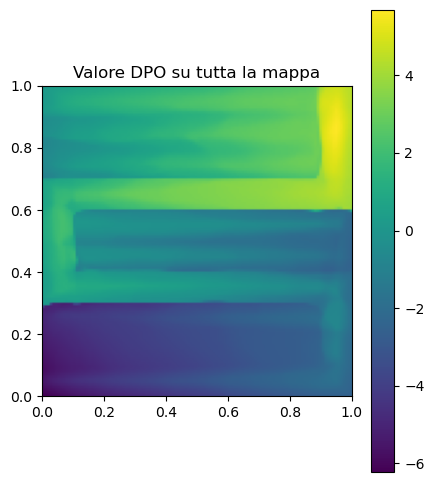

In [6]:
def plot_value_heatmap(env, n=120):
    # campiona n×n punti su tutta la mappa e valuta la rete DPO
    xs = np.linspace(0, 1, n)
    ys = np.linspace(0, 1, n)
    xx, yy = np.meshgrid(xs, ys)
    pts = np.stack([xx.ravel(), yy.ravel()], axis=1)
    with torch.no_grad():
        vals = env.policy_net(
            (torch.tensor(pts, device=env.device, dtype=torch.float32)
             - env._mean) / env._std
        ).cpu().numpy().reshape(n, n)
    plt.figure(figsize=(5,6))
    plt.title("Valore DPO su tutta la mappa")
    plt.imshow(vals, origin="lower", extent=[0,1,0,1], cmap="viridis")
    plt.colorbar(); plt.show()

plot_value_heatmap(env=env_dpo)

1) Enviroment (preference maze - maze laby with S)
2) greedy fails 
3) the way in which we define the preference function influence a lot the DPO